# NLTK Chapter 9

## Building Feature Based Grammars

*The html version of this chapter in the book is available [here](https://www.nltk.org/book/ch09.html "ch09").*

### 1   Grammatical Features

We're now going to declare the features of words and phrases.  Here's an example of using dictionaries to store features and their values:

In [1]:
kim = {'CAT': 'NP', 'ORTH': 'Kim', 'REF': 'k'}
chase = {'CAT': 'V', 'ORTH': 'chased', 'REL': 'chase'}

__Feature structures__ are the pairings of features and values.

Adding more properties to the verb *chase*.  The subject plays the role of "agent" and the object the role of "patient".

In [2]:
chase['AGT'] = 'sbj'
chase['PAT'] = 'obj'

The rather convoluted code that follows processes the sentence *Kim chased Lee* and "binds" the verb's agent role to the subject (because it's to the left of the verb) and patient role to the object (because it's to the right of the verb).

In [3]:
sent = "Kim chased Lee"
tokens = sent.split()
lee = {'CAT': 'NP', 'ORTH': 'Lee', 'REF': 'l'}

def lex2fs(word):
    for fs in [kim, lee, chase]:
        if fs['ORTH'] == word:
            return fs
        
subj, verb, obj = lex2fs(tokens[0]), lex2fs(tokens[1]), lex2fs(tokens[2])
verb['AGT'] = subj['REF']
verb['PAT'] = obj['REF']

for k in ['ORTH', 'REL', 'AGT', 'PAT']:
    print("%-5s => %s" % (k, verb[k]))

ORTH  => chased
REL   => chase
AGT   => k
PAT   => l


#### 1.1   Syntactic Agreement

This simple grammar would permit *This dog runs*, but it would also permit sentences where the noun and verb don't agree, such as <i>*Theses dogs runs<i>.

In [4]:
import nltk

simple_grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Det N 
VP -> V
Det -> 'this' | 'these'
N -> 'dog' | 'dogs'
V -> 'runs'
""")

This more complex grammar would block sentences without agreement:

In [5]:
complex_grammar = nltk.CFG.fromstring("""
S -> NP_SG VP_SG
S -> NP_PL VP_PL
NP_SG -> Det_SG N_SG
NP_PL -> Det_PL N_PL
VP_SG -> V_SG
VP_PL -> V_PL

Det_SG -> 'this'
Det_PL -> 'these'
N_SG -> 'dog'
N_PL -> 'dogs'
V_SG -> 'runs'
V_PL -> 'run'
""")

In effect, we've doubled the size of our grammar.  If we needed agreement for first, second and thrid person as well, this method would result in a grammar that would be six times the size of our original `simple` grammar.  We will look at ways of streamlining this.

#### 1.2 Using Attributes and Constraints

We could add __features__ to our notation, and use variables over values to reduce the number of required productions.

```
S[NUM = ?n] -> NP[NUM = ?n] VP[NUM = ?n]
NP[NUM = ?n] -> Det[NUM = ?n] N[NUM = ?n]
VP[NUM = ?n] -> V[NUM = ?n]
Det[NUM = sg] -> 'this'
Det[NUM = pl] -> 'these'
N[NUM = sg] -> 'dog'
N[NUM = pl] -> 'dogs'
V[NUM = sg] -> 'runs'
V[NUM = pl] -> 'run'
```

Naturally, there has to be agreement now, or the parse will fail.  

For words that agree with all numbers (i.e., singular and plural), we can leave the `NUM` value __underspecified__ instead of declaring it twice.

```
S[NUM = ?n] -> NP[NUM = ?n] VP[NUM = ?n]
NP[NUM = ?n] -> Det[NUM = ?n] N[NUM = ?n]
VP[NUM = ?n] -> V[NUM = ?n]

Det[NUM = sg] -> 'this'
Det[NUM = pl] -> 'these'
N[NUM = sg] -> 'dog'
N[NUM = pl] -> 'dogs'
V[NUM = sg] -> 'runs'
V[NUM = pl] -> 'run'
Det[NUM = ?n] -> 'the' | 'some' | 'any'
```

Most of the ideas from this chapter - and a few more - can be found in the grammar below:

In [8]:
nltk.data.show_cfg('grammars/book_grammars/feat0.fcfg')

% start S
# ###################
# Grammar Productions
# ###################
# S expansion productions
S -> NP[NUM=?n] VP[NUM=?n]
# NP expansion productions
NP[NUM=?n] -> N[NUM=?n] 
NP[NUM=?n] -> PropN[NUM=?n] 
NP[NUM=?n] -> Det[NUM=?n] N[NUM=?n]
NP[NUM=pl] -> N[NUM=pl] 
# VP expansion productions
VP[TENSE=?t, NUM=?n] -> IV[TENSE=?t, NUM=?n]
VP[TENSE=?t, NUM=?n] -> TV[TENSE=?t, NUM=?n] NP
# ###################
# Lexical Productions
# ###################
Det[NUM=sg] -> 'this' | 'every'
Det[NUM=pl] -> 'these' | 'all'
Det -> 'the' | 'some' | 'several'
PropN[NUM=sg]-> 'Kim' | 'Jody'
N[NUM=sg] -> 'dog' | 'girl' | 'car' | 'child'
N[NUM=pl] -> 'dogs' | 'girls' | 'cars' | 'children' 
IV[TENSE=pres,  NUM=sg] -> 'disappears' | 'walks'
TV[TENSE=pres, NUM=sg] -> 'sees' | 'likes'
IV[TENSE=pres,  NUM=pl] -> 'disappear' | 'walk'
TV[TENSE=pres, NUM=pl] -> 'see' | 'like'
IV[TENSE=past] -> 'disappeared' | 'walked'
TV[TENSE=past] -> 'saw' | 'liked'


Using this grammar with a parser:

In [9]:
tokens = 'Kim likes children'.split()
from nltk import load_parser
cp = load_parser('grammars/book_grammars/feat0.fcfg', trace = 2)
for tree in cp.parse(tokens):
    print(tree)

|.Kim .like.chil.|
Leaf Init Rule:
|[----]    .    .| [0:1] 'Kim'
|.    [----]    .| [1:2] 'likes'
|.    .    [----]| [2:3] 'children'
Feature Bottom Up Predict Combine Rule:
|[----]    .    .| [0:1] PropN[NUM='sg'] -> 'Kim' *
Feature Bottom Up Predict Combine Rule:
|[----]    .    .| [0:1] NP[NUM='sg'] -> PropN[NUM='sg'] *
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] S[] -> NP[NUM=?n] * VP[NUM=?n] {?n: 'sg'}
Feature Bottom Up Predict Combine Rule:
|.    [----]    .| [1:2] TV[NUM='sg', TENSE='pres'] -> 'likes' *
Feature Bottom Up Predict Combine Rule:
|.    [---->    .| [1:2] VP[NUM=?n, TENSE=?t] -> TV[NUM=?n, TENSE=?t] * NP[] {?n: 'sg', ?t: 'pres'}
Feature Bottom Up Predict Combine Rule:
|.    .    [----]| [2:3] N[NUM='pl'] -> 'children' *
Feature Bottom Up Predict Combine Rule:
|.    .    [----]| [2:3] NP[NUM='pl'] -> N[NUM='pl'] *
Feature Bottom Up Predict Combine Rule:
|.    .    [---->| [2:3] S[] -> NP[NUM=?n] * VP[NUM=?n] {?n: 'pl'}
Feature Single Edge Fundame

#### 1.3   Terminology

Values like `sg` and `pl` are __atomic__ because they can't be decomposed into subparts.  We can use a __boolean__ value to distinguish __auxiliary__ verbs (e.g., modal verbs) with the boolean feature `AUX`.  For example, *can* could be represented with the production `V[TENSE=pres, AUX=+]`, though the convention is to put the `+/-` sign in front of the feature, like so: 

```
V[TENSE=pres, +AUX] -> 'can'
V[TENSE=pres, +AUX] -> 'may'

V[TENSE=pres, -AUX] -> 'walks'
V[TENSE=pres, -AUX] -> 'likes'
```

We could also group together the features in an __attribute value matrix__ (AVM). `AGR` stands for *agreement*.

```
[POS = N           ]
[                  ]
[AGR = [PER = 3   ]]
[      [NUM = pl  ]]
[      [GND = fem ]]
```

Order does not matter in representation, so this would be equivalent:

```
[AGR = [NUM = pl  ]]
[      [PER = 3   ]]
[      [GND = fem ]]
[                  ]
[POS = N           ]
```

We could then refactor a grammar so that agreement features are bundled together like so:

```
S                    -> NP[AGR=?n] VP[AGR=?n]
NP[AGR=?n]           -> PropN[AGR=?n]
VP[TENSE=?t, AGR=?n] -> Cop[TENSE=?t, AGR=?n] Adj

Cop[TENSE=pres,  AGR=[NUM=sg, PER=3]] -> 'is'
PropN[AGR=[NUM=sg, PER=3]]            -> 'Kim'
Adj                                   -> 'happy'
```

__NOTE__: The book doesn't really do a great job of showing us how to set up Feature Grammar Parsing. We are required to do just this for the first exercise in the unit, but unfortunately there is not enough information in the chapter to carry this off.  Cf. [this nltk tutorial](http://www.nltk.org/howto/featgram.html "Feature Grammar Parsing") for more information, but be aware that I still needed to futz around a bit before I got something to work.

### 2   Processing Feature Structures

Use `FeatStruct()` to declare feature structures:

In [3]:
fs1 = nltk.FeatStruct(TENSE = 'past', NUM = 'sg')
print(fs1)

[ NUM   = 'sg'   ]
[ TENSE = 'past' ]


Feature structures are technically a kind of dictionary, so normal dictionary operations will work on them:

In [4]:
fs1 = nltk.FeatStruct(PER = 3, NUM = 'pl', GND = 'fem')
print(fs1['GND'])

fem


In [5]:
fs1['CASE'] = 'acc'

We can also define structures that have complex values:

In [7]:
fs2 = nltk.FeatStruct(POS = 'N', AGR = fs1)
print(fs2)

[       [ CASE = 'acc' ] ]
[ AGR = [ GND  = 'fem' ] ]
[       [ NUM  = 'pl'  ] ]
[       [ PER  = 3     ] ]
[                        ]
[ POS = 'N'              ]


In [8]:
print(fs2['AGR'])

[ CASE = 'acc' ]
[ GND  = 'fem' ]
[ NUM  = 'pl'  ]
[ PER  = 3     ]


In [9]:
print(fs2['AGR']['PER'])

3


An alternative method is to use a brackted string:

In [10]:
print(nltk.FeatStruct("[POS = 'N', AGR = [PER = 3, NUM = 'pl', GND = 'fem']]"))

[       [ GND = 'fem' ] ]
[ AGR = [ NUM = 'pl'  ] ]
[       [ PER = 3     ] ]
[                       ]
[ POS = 'N'             ]


Feature structures are not limited to linguistic objects:

In [11]:
print(nltk.FeatStruct(NAME = 'Lee', TELNO = '01 27 86 42 96', AGE = 33))

[ AGE   = 33               ]
[ NAME  = 'Lee'            ]
[ TELNO = '01 27 86 42 96' ]


We can view feature structures as __directed acyclic graphs__ (DAGs):

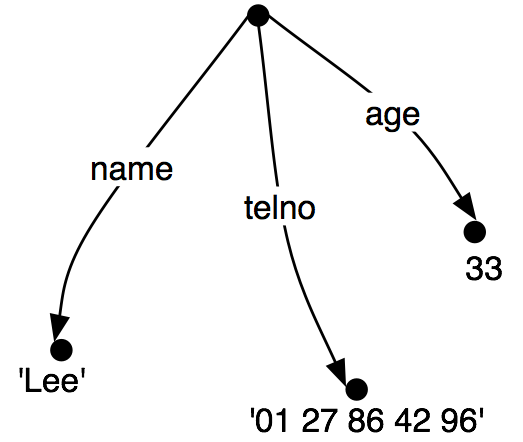

In [12]:
from IPython.display import display, Image

display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\dag01.png"))

Feature values can be complex:

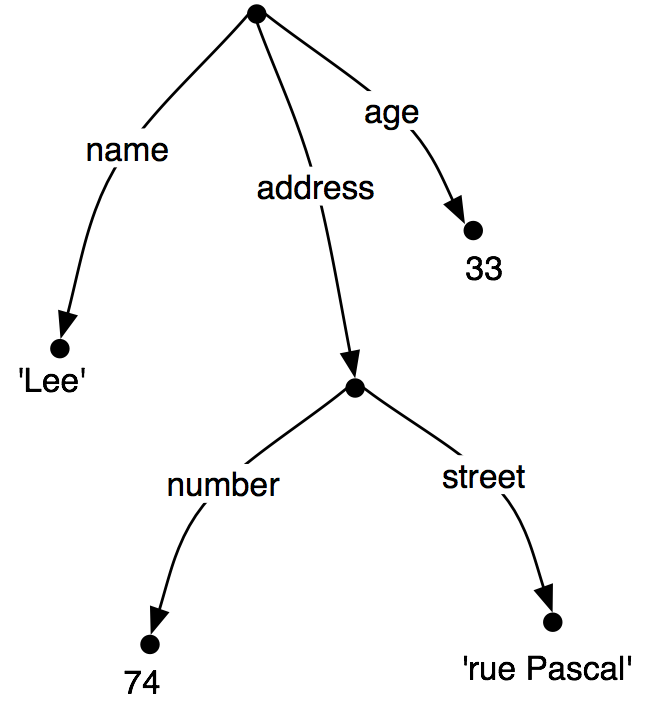

In [13]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\dag02.png"))

A __feature path__ is a sequence of arcs that can be followed from the root node.  Ergo, `('ADDRESS', 'STREET')` is a feature path whose value is the node label `rue Pascal`.

If Lee had a spouse named *Kim*, it would follow that they would have the same address.  We could represent that information like this:

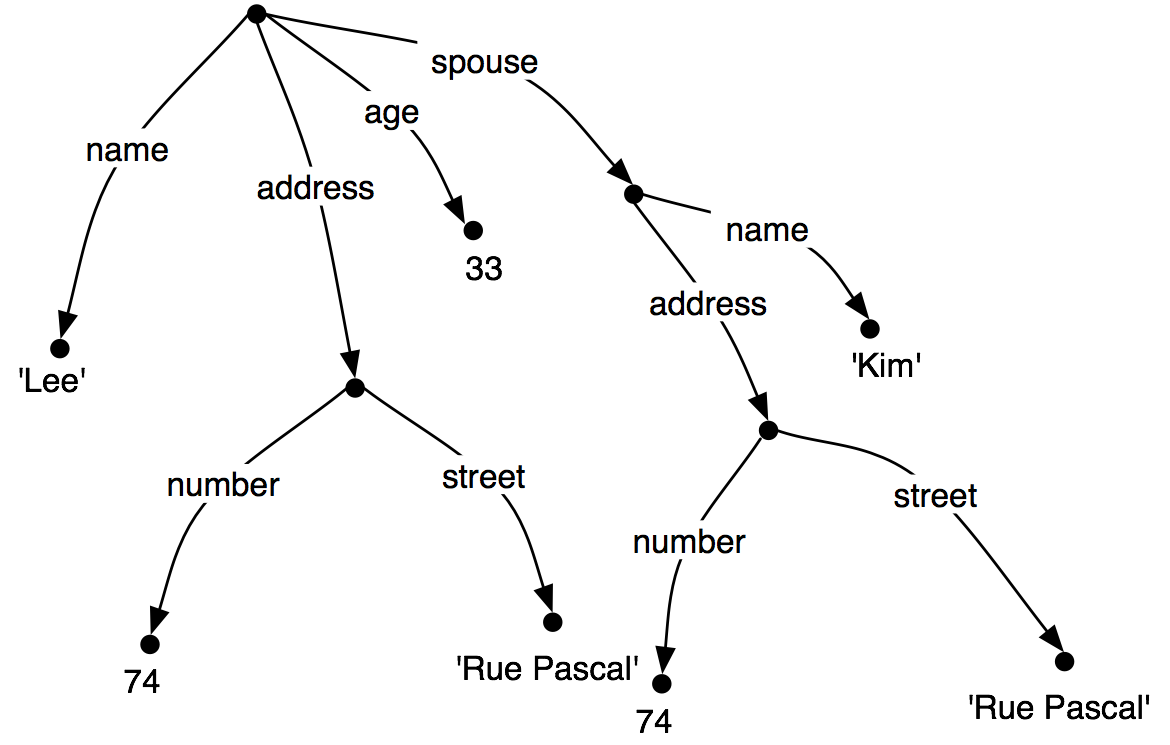

In [14]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\dag04.png"))

Or we could 'share' the sub-graph between different arcs:

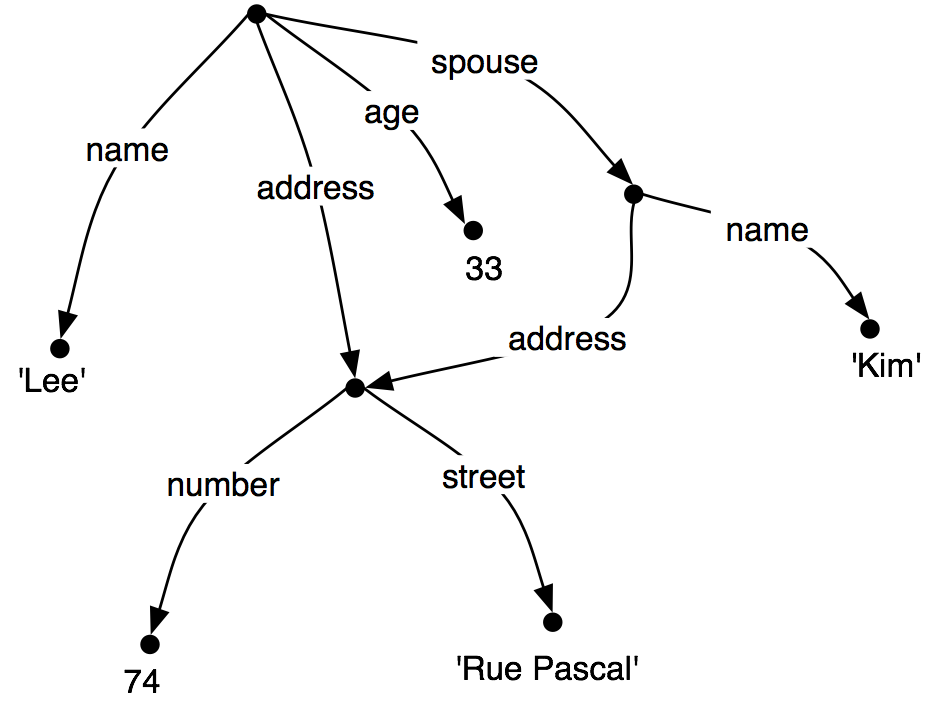

In [15]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\dag03.png"))

These DAGs involve __structure sharing__ or __reentrancy__.  If two paths have the same value, we say they are __equivalent__.

To indicate reentrancy, we will prefix the first occurrence of a shared feature stucture with an integer in parentheses.  Later references will use that notation:

In [16]:
print(nltk.FeatStruct("""[NAME = 'Lee', 
                          ADDRESS = (1) [NUMBER = 74, 
                                         STREET = 'rue Pascal'],
                          SPOUSE = [NAME = 'Kim', 
                                    ADDRESS -> (1)]]"""))

[ ADDRESS = (1) [ NUMBER = 74           ] ]
[               [ STREET = 'rue Pascal' ] ]
[                                         ]
[ NAME    = 'Lee'                         ]
[                                         ]
[ SPOUSE  = [ ADDRESS -> (1)  ]           ]
[           [ NAME    = 'Kim' ]           ]


These bracketed integers are called __tags__ or __coindices__.  We can use any number of tags within a single feature structure.

In [17]:
print(nltk.FeatStruct("[A = 'a', B = (1)[C = 'c'], D -> (1), E -> (1)]"))

[ A = 'a'             ]
[                     ]
[ B = (1) [ C = 'c' ] ]
[                     ]
[ D -> (1)            ]
[ E -> (1)            ]


#### 2.1 Subsumption and Unification

We think of feature structures as providing __partial information__ about objects, and we can order these structures based on how much information they contain.  The following three structures are ordered by increasing amounts of information:

a.

`[NUMBER = 74]`

b.		

`[NUMBER = 74          ]
 [STREET = 'rue Pascal']`

c.		

`[NUMBER = 74          ]
 [STREET = 'rue Pascal']
 [CITY = 'Paris'       ]`


This ordering is called __subsumption__. $FS_0$ subsumes $FS_1$ if all information in $FS_0$ is also in $FS_1$.  We use the symbol $\sqsubseteq$ to represent subsumption.

But we need to be more careful when we add the possibility of reentrancy.  If $FS_0 \sqsubseteq FS_1$, then $FS_1$ must have all the paths and reentrancies of $FS_0$. 

Merging information from two feature structures is called __unification__, and is supported by the `unify()` method.

In [18]:
fs1 = nltk.FeatStruct(NUMBER = 74, STREET = 'rue Pascal')
fs2 = nltk.FeatStruct(CITY = 'Paris')
print(fs1.unify(fs2))

[ CITY   = 'Paris'      ]
[ NUMBER = 74           ]
[ STREET = 'rue Pascal' ]


Unification is a (partial) binary operation: $FS_0 \sqcup FS_1$.  Unification is binary, so $FS_0 \sqcup FS_1 = FS_1 \sqcup FS_0$.  The same is true in Python:

In [19]:
print(fs2.unify(fs1))

[ CITY   = 'Paris'      ]
[ NUMBER = 74           ]
[ STREET = 'rue Pascal' ]


If we unify two feature structures in a subsumption relationship, the result is the more informative of the two. E.g., if $FS_0 \sqsubseteq FS_1$, then $FS_0 \sqcup FS_1 = FS_1$

If two feature structures share a path but have distinct values, the unification will fail:

In [21]:
fs0 = nltk.FeatStruct(A = 'a')
fs1 = nltk.FeatStruct(A = 'b')
fs2 = fs0.unify(fs1)
print(fs2)

None


Let's consider how unification interacts with structure sharing.  Let's define one of the DAGs from above:

In [22]:
fs0 = nltk.FeatStruct("""[NAME = Lee,
                          ADDRESS = [NUMBER = 74,
                                     STREET = 'rue Pascal'],
                          SPOUSE =  [NAME = Kim,
                                     ADDRESS = [NUMBER = 74,
                                                STREET = 'rue Pascal']]]""")
print(fs0)

[ ADDRESS = [ NUMBER = 74           ]               ]
[           [ STREET = 'rue Pascal' ]               ]
[                                                   ]
[ NAME    = 'Lee'                                   ]
[                                                   ]
[           [ ADDRESS = [ NUMBER = 74           ] ] ]
[ SPOUSE  = [           [ STREET = 'rue Pascal' ] ] ]
[           [                                     ] ]
[           [ NAME    = 'Kim'                     ] ]


Let's augment Kim's address with a specification for `CITY`.  Notice that we need to include the whole path:

In [24]:
fs1 = nltk.FeatStruct("[SPOUSE = [ADDRESS = [CITY = Paris]]]")
print(fs1.unify(fs0))

[ ADDRESS = [ NUMBER = 74           ]               ]
[           [ STREET = 'rue Pascal' ]               ]
[                                                   ]
[ NAME    = 'Lee'                                   ]
[                                                   ]
[           [           [ CITY   = 'Paris'      ] ] ]
[           [ ADDRESS = [ NUMBER = 74           ] ] ]
[ SPOUSE  = [           [ STREET = 'rue Pascal' ] ] ]
[           [                                     ] ]
[           [ NAME    = 'Kim'                     ] ]


The result would have been different if we had been sharing structures:

In [25]:
fs2 = nltk.FeatStruct("""[NAME = Lee, ADDRESS = (1) [NUMBER = 74,
                                                     STREET = 'rue Pascal'],
                                      SPOUSE = [Name = Kim, ADDRESS ->(1)]]""")
print(fs1.unify(fs2))

[               [ CITY   = 'Paris'      ] ]
[ ADDRESS = (1) [ NUMBER = 74           ] ]
[               [ STREET = 'rue Pascal' ] ]
[                                         ]
[ NAME    = 'Lee'                         ]
[                                         ]
[ SPOUSE  = [ ADDRESS -> (1)  ]           ]
[           [ Name    = 'Kim' ]           ]


We can also use variables such as `?x` for structure sharing:

In [28]:
fs1 = nltk.FeatStruct("[ADDRESS1 = [NUMBER = 74, STREET = 'rue Pascal']]")
fs2 = nltk.FeatStruct("[ADDRESS1 = ?x, ADDRESS2 = ?x]")
print(fs2)

[ ADDRESS1 = ?x ]
[ ADDRESS2 = ?x ]


In [29]:
print(fs2.unify(fs1))

[ ADDRESS1 = (1) [ NUMBER = 74           ] ]
[                [ STREET = 'rue Pascal' ] ]
[                                          ]
[ ADDRESS2 -> (1)                          ]


### 3 Extending a Feature based Grammar

#### 3.1 Subcategorization

Subcategorization allows us to make general distinctions across entire categories.  This was originally developed for a grammar framework called Generalized Phrase Structure Grammar (GPSG).

```
VP[TENSE=?t, NUM=?n] -> V[SUBCAT=intrans, TENSE=?t, NUM=?n]
VP[TENSE=?t, NUM=?n] -> V[SUBCAT=trans, TENSE=?t, NUM=?n] NP
VP[TENSE=?t, NUM=?n] -> V[SUBCAT=clause, TENSE=?t, NUM=?n] SBar

V[SUBCAT=intrans, TENSE=pres, NUM=sg] -> 'disappears' | 'walks'
V[SUBCAT=trans, TENSE=pres, NUM=sg] -> 'sees' | 'likes'
V[SUBCAT=clause, TENSE=pres, NUM=sg] -> 'says' | 'claims'

V[SUBCAT=intrans, TENSE=pres, NUM=pl] -> 'disappear' | 'walk'
V[SUBCAT=trans, TENSE=pres, NUM=pl] -> 'see' | 'like'
V[SUBCAT=clause, TENSE=pres, NUM=pl] -> 'say' | 'claim'

V[SUBCAT=intrans, TENSE=past, NUM=?n] -> 'disappeared' | 'walked'
V[SUBCAT=trans, TENSE=past, NUM=?n] -> 'saw' | 'liked'
V[SUBCAT=clause, TENSE=past, NUM=?n] -> 'said' | 'claimed'

```

`SBar` refers to subordinate clauses.  They require two further productions:

```
SBar -> Comp S
Comp -> 'that'

```

Here is an example tree:

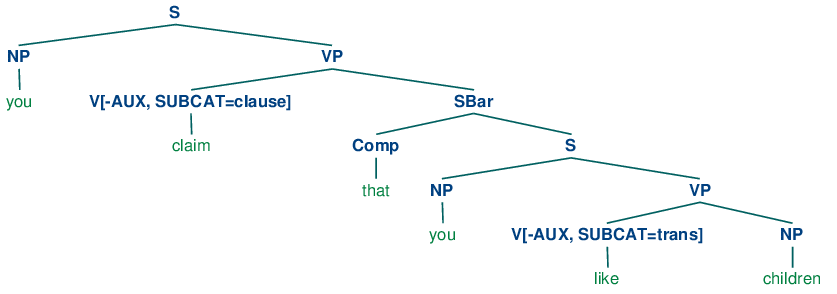

In [30]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\ch09-tree-10.png"))

Another form of subcategorization directly encodes the valency of a head (i.e., the list of arguments that it can combine with).  E.g., *put* might be represented as `V[SUBCAT=<NP, NP, PP>]`, as in *put the book on the table*.

#### 3.2 Heads Revisited

X-bar Syntax represents the parent / head-child relation by abstracting out the notion of __phrasal level__.  If `N` represents the lexical level, `N'` represents the next level up, and `N"` represents the phrasal level.  Here is a tree:

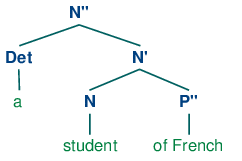

In [31]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\ch09-tree-12.png"))

`N'` and `N"` are called __(phrasal) projections__.  `N"` is the __maximal projection__, and `N` is sometimes called the __zero projection__.  Here is an example of Python code:

`
S -> N[BAR=2] V[BAR=2]
N[BAR=2] -> Det N[BAR=1]
N[BAR=1] -> N[BAR=1] P[BAR=2]
N[BAR=1] -> N[BAR=0] P[BAR=2]
N[BAR=1] -> N[BAR=0]XS
`

#### 3.3   Auxiliary Verbs and Inversion

Negative adverbs can begin sentences in English, but this requires an auxiliary verb.  E.g., "Rarely do you see Kim."  This production is how we could capture such a structure:

`S[+INV] -> V[+AUX] NP VP`

#### 3.4 Unbounded Dependency Constructions

Verbs such as like require an `NP` complement, but complements can be omitted in sentences like 'Kim knows who you like', because *who* serves as a __filler__.  We might say that sentences without these complements have __gaps__, and sometimes these gaps are made explicit with an underscore, e.g. 'Kim knows who you like \__'.

The mutual co-occurrence between filler and gap is sometimes termed a "dependency", and there is an upper bound on the distance between filler and gap.  But sentences can have indefinitely deep recursion of sentential complements, meaning that the gap can be embedded indefinitely far inside the whole sentence.  This leads to the notion of the __unbounded dependency construction__, where there is no upper bound on the distance between filler and gap.  

One mechanism for handling unbounded dependencies involves __slash categories__ in the form `Y/XP`, where a pharse of category `Y` is missing a sub-constituent of category `XP`.  Here is an example:






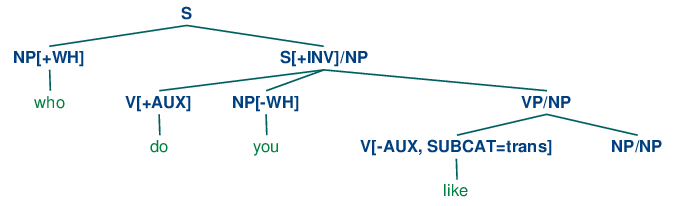

In [32]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\ch09-tree-16.png"))

The grammar below illustrates the main principles of slash categories, and also includes productions for inverted clauses:

In [33]:
nltk.data.show_cfg('grammars/book_grammars/feat1.fcfg')

% start S
# ###################
# Grammar Productions
# ###################
S[-INV] -> NP VP
S[-INV]/?x -> NP VP/?x
S[-INV] -> NP S/NP
S[-INV] -> Adv[+NEG] S[+INV]
S[+INV] -> V[+AUX] NP VP
S[+INV]/?x -> V[+AUX] NP VP/?x
SBar -> Comp S[-INV]
SBar/?x -> Comp S[-INV]/?x
VP -> V[SUBCAT=intrans, -AUX]
VP -> V[SUBCAT=trans, -AUX] NP
VP/?x -> V[SUBCAT=trans, -AUX] NP/?x
VP -> V[SUBCAT=clause, -AUX] SBar
VP/?x -> V[SUBCAT=clause, -AUX] SBar/?x
VP -> V[+AUX] VP
VP/?x -> V[+AUX] VP/?x
# ###################
# Lexical Productions
# ###################
V[SUBCAT=intrans, -AUX] -> 'walk' | 'sing'
V[SUBCAT=trans, -AUX] -> 'see' | 'like'
V[SUBCAT=clause, -AUX] -> 'say' | 'claim'
V[+AUX] -> 'do' | 'can'
NP[-WH] -> 'you' | 'cats'
NP[+WH] -> 'who'
Adv[+NEG] -> 'rarely' | 'never'
NP/NP ->
Comp -> 'that'


Parsing 'who do you claim that you like':

In [34]:
tokens = 'who do you claim that you like'.split()
from nltk import load_parser
cp = load_parser('grammars/book_grammars/feat1.fcfg')
for tree in cp.parse(tokens):
    print(tree)

(S[-INV]
  (NP[+WH] who)
  (S[+INV]/NP[]
    (V[+AUX] do)
    (NP[-WH] you)
    (VP[]/NP[]
      (V[-AUX, SUBCAT='clause'] claim)
      (SBar[]/NP[]
        (Comp[] that)
        (S[-INV]/NP[]
          (NP[-WH] you)
          (VP[]/NP[] (V[-AUX, SUBCAT='trans'] like) (NP[]/NP[] )))))))


The tree above drawn out:

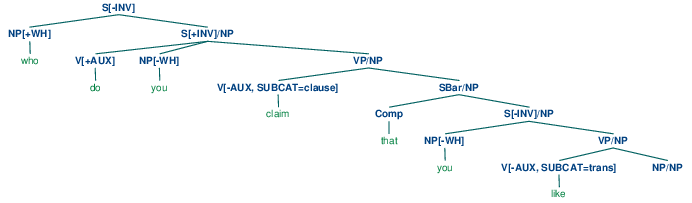

In [35]:
display(Image(filename = "C:\\Users\\mjcor\\Desktop\\ProgrammingStuff\\nltk\\ch09-tree-17.png"))

This grammar will also parse sentences without gaps:

In [36]:
tokens = 'you claim that you like cats'.split()
for tree in cp.parse(tokens):
    print(tree)

(S[-INV]
  (NP[-WH] you)
  (VP[]
    (V[-AUX, SUBCAT='clause'] claim)
    (SBar[]
      (Comp[] that)
      (S[-INV]
        (NP[-WH] you)
        (VP[] (V[-AUX, SUBCAT='trans'] like) (NP[-WH] cats))))))


It will also admit inverted sentences which do not involve *wh* constructions:

In [37]:
tokens = 'rarely do you sing'.split()
for tree in cp.parse(tokens):
    print(tree)

(S[-INV]
  (Adv[+NEG] rarely)
  (S[+INV]
    (V[+AUX] do)
    (NP[-WH] you)
    (VP[] (V[-AUX, SUBCAT='intrans'] sing))))


#### 3.5   Case and Gender in German

This grammar illustrates the interaction of agreement (comprising person, number and gender) with case:

In [38]:
nltk.data.show_cfg('grammars/book_grammars/german.fcfg')

% start S
# Grammar Productions
S -> NP[CASE=nom, AGR=?a] VP[AGR=?a]
NP[CASE=?c, AGR=?a] -> PRO[CASE=?c, AGR=?a]
NP[CASE=?c, AGR=?a] -> Det[CASE=?c, AGR=?a] N[CASE=?c, AGR=?a]
VP[AGR=?a] -> IV[AGR=?a]
VP[AGR=?a] -> TV[OBJCASE=?c, AGR=?a] NP[CASE=?c]
# Lexical Productions
# Singular determiners
# masc
Det[CASE=nom, AGR=[GND=masc,PER=3,NUM=sg]] -> 'der' 
Det[CASE=dat, AGR=[GND=masc,PER=3,NUM=sg]] -> 'dem'
Det[CASE=acc, AGR=[GND=masc,PER=3,NUM=sg]] -> 'den'
# fem
Det[CASE=nom, AGR=[GND=fem,PER=3,NUM=sg]] -> 'die' 
Det[CASE=dat, AGR=[GND=fem,PER=3,NUM=sg]] -> 'der'
Det[CASE=acc, AGR=[GND=fem,PER=3,NUM=sg]] -> 'die' 
# Plural determiners
Det[CASE=nom, AGR=[PER=3,NUM=pl]] -> 'die' 
Det[CASE=dat, AGR=[PER=3,NUM=pl]] -> 'den' 
Det[CASE=acc, AGR=[PER=3,NUM=pl]] -> 'die' 
# Nouns
N[AGR=[GND=masc,PER=3,NUM=sg]] -> 'Hund'
N[CASE=nom, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunde'
N[CASE=dat, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunden'
N[CASE=acc, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunde'
N[AGR=[GND=fem,PER=3,

Here is an example of a parse tree for a sentence with a verb which governs the dative case:

In [39]:
tokens = 'ich folge den Katzen'.split()
cp = load_parser('grammars/book_grammars/german.fcfg')
for tree in cp.parse(tokens):
    print(tree)

(S[]
  (NP[AGR=[NUM='sg', PER=1], CASE='nom']
    (PRO[AGR=[NUM='sg', PER=1], CASE='nom'] ich))
  (VP[AGR=[NUM='sg', PER=1]]
    (TV[AGR=[NUM='sg', PER=1], OBJCASE='dat'] folge)
    (NP[AGR=[GND='fem', NUM='pl', PER=3], CASE='dat']
      (Det[AGR=[NUM='pl', PER=3], CASE='dat'] den)
      (N[AGR=[GND='fem', NUM='pl', PER=3]] Katzen))))


If we set `trace`, we can see how a sentence fails to parse:

In [40]:
tokens = 'ich folge den Katze'.split()
cp = load_parser('grammars/book_grammars/german.fcfg', trace = 2)
for tree in cp.parse(tokens):
    print(tree)

|.ich.fol.den.Kat.|
Leaf Init Rule:
|[---]   .   .   .| [0:1] 'ich'
|.   [---]   .   .| [1:2] 'folge'
|.   .   [---]   .| [2:3] 'den'
|.   .   .   [---]| [3:4] 'Katze'
Feature Bottom Up Predict Combine Rule:
|[---]   .   .   .| [0:1] PRO[AGR=[NUM='sg', PER=1], CASE='nom'] -> 'ich' *
Feature Bottom Up Predict Combine Rule:
|[---]   .   .   .| [0:1] NP[AGR=[NUM='sg', PER=1], CASE='nom'] -> PRO[AGR=[NUM='sg', PER=1], CASE='nom'] *
Feature Bottom Up Predict Combine Rule:
|[--->   .   .   .| [0:1] S[] -> NP[AGR=?a, CASE='nom'] * VP[AGR=?a] {?a: [NUM='sg', PER=1]}
Feature Bottom Up Predict Combine Rule:
|.   [---]   .   .| [1:2] TV[AGR=[NUM='sg', PER=1], OBJCASE='dat'] -> 'folge' *
Feature Bottom Up Predict Combine Rule:
|.   [--->   .   .| [1:2] VP[AGR=?a] -> TV[AGR=?a, OBJCASE=?c] * NP[CASE=?c] {?a: [NUM='sg', PER=1], ?c: 'dat'}
Feature Bottom Up Predict Combine Rule:
|.   .   [---]   .| [2:3] Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='acc'] -> 'den' *
|.   .   [---]   .| [2:3] Det[AGR=[

### 4 Summary

*__No notes.__*

### 5 Further Reading

*__No notes.__*

### 6 Exercises

##### 1. 

☼ What constraints are required to correctly parse word sequences like I am happy and she is happy but not *you is happy or *they am happy? Implement two solutions for the present tense paradigm of the verb be in English, first taking Grammar [(6)](https://www.nltk.org/book/ch09.html#ex-agcfg1) as your starting point, and then taking Grammar [(18)](https://www.nltk.org/book/ch09.html#ex-agr2) as the starting point.

*The first grammar involves a __lot__ of redundancy:*

In [53]:
grammar = nltk.CFG.fromstring("""
S -> NP_SG_1 VP_SG_1
S -> NP_SG_2 VP_SG_2
S -> NP_SG_3 VP_SG_3
S -> NP_PL VP_PL
NP_SG_1 -> N_SG_1
NP_SG_2 -> N_SG_2
NP_SG_3 -> N_SG_3
NP_PL -> N_PL_1 | N_PL_2 | N_PL_3
VP_SG_1 -> V_SG_1 ADJ
VP_SG_2 -> V_SG_2 ADJ
VP_SG_3 -> V_SG_3 ADJ
VP_PL -> V_PL ADJ
N_SG_1 -> "I"
N_SG_2 -> "you"
N_SG_3 -> "he" | "she" | "it"
N_PL_1 -> "we"
N_PL_2 -> "you"
N_PL_3 -> "they"
V_SG_1 -> "am"
V_SG_2 -> "are"
V_SG_3 -> "is"
V_PL   -> "are"
ADJ -> "happy"
""")

In [54]:
sent = "I am happy".split()
parser = nltk.ChartParser(grammar)
for tree in parser.parse(sent):
    print(tree)

(S (NP_SG_1 (N_SG_1 I)) (VP_SG_1 (V_SG_1 am) (ADJ happy)))


In [55]:
sent = "she is happy".split()
for tree in parser.parse(sent):
    print(tree)

(S (NP_SG_3 (N_SG_3 she)) (VP_SG_3 (V_SG_3 is) (ADJ happy)))


*If our grammar is correct, the next two sentences won't produce any parses:*

In [56]:
sent = "you is happy".split()
for tree in parser.parse(sent):
    print(tree)

In [57]:
sent = "they am happy".split()
for tree in parser.parse(sent):
    print(tree)

The second grammar was a bit difficult to set up. In my opinion, much more difficult than should be expected for part of the first question in an exercise set.  I couldn't find anything in the book to help me, and had to resort to [an external nltk tutorial](http://www.nltk.org/howto/featgram.html "Feature Grammar Parsing") in order to answer this exercise. 

In [157]:
from nltk import grammar, parse

g = """
% start S
S -> NP[AGR = ?n] VP[AGR = ?n]
NP[AGR = ?n] -> N[AGR = ?n]
VP[AGR = ?n] -> V[AGR = ?n] ADJ
N[AGR = [PER = 1, NUM = sg]] -> "I"
N[AGR = [PER = 2, NUM = sg]] -> "you"
N[AGR = [PER = 3, NUM = sg]] -> "he" | "she" | "it"
N[AGR = [PER = 1, NUM = pl]] -> "we"
N[AGR = [PER = 2, NUM = pl]] -> "you"
N[AGR = [PER = 3, NUM = pl]]-> "they"
V[AGR = [PER = 1, NUM = sg]] -> "am" 
V[AGR = [PER = 2, NUM = sg]] -> "are" 
V[AGR = [PER = 3, NUM = sg]] -> "is" 
V[AGR = [PER = ?n, NUM = pl]]  -> "are" 
ADJ -> "happy"
"""

gram = grammar.FeatureGrammar.fromstring(g)
parser = parse.FeatureEarleyChartParser(gram)

In [158]:
sent = "I am happy".split()

for tree in parser.parse(sent):
    print(tree)

(S[]
  (NP[AGR=[NUM='sg', PER=1]] (N[AGR=[NUM='sg', PER=1]] I))
  (VP[AGR=[NUM='sg', PER=1]]
    (V[AGR=[NUM='sg', PER=1]] am)
    (ADJ[] happy)))


In [159]:
sent = "she is happy".split()
for tree in parser.parse(sent):
    print(tree)

(S[]
  (NP[AGR=[NUM='sg', PER=3]] (N[AGR=[NUM='sg', PER=3]] she))
  (VP[AGR=[NUM='sg', PER=3]]
    (V[AGR=[NUM='sg', PER=3]] is)
    (ADJ[] happy)))


In [160]:
sent = "they are happy".split()
for tree in parser.parse(sent):
    print(tree)

(S[]
  (NP[AGR=[NUM='pl', PER=3]] (N[AGR=[NUM='pl', PER=3]] they))
  (VP[AGR=[NUM='pl', PER=?n2]]
    (V[AGR=[NUM='pl', PER=?n]] are)
    (ADJ[] happy)))


*If our grammar is correct, the next two sentences won't produce any parses:*

In [161]:
sent = "you is happy".split()
for tree in parser.parse(sent):
    print(tree)

In [162]:
sent = "they am happy".split()
for tree in parser.parse(sent):
    print(tree)

##### 2.

☼ Develop a variant of grammar in [1.1](https://www.nltk.org/book/ch09.html#code-feat0cfg) that uses a feature count to make the distinctions shown below:

(54)

* a. The boy sings.

* b. *Boy sings.

(55)

* a. The boys sings.

* b. Boys sing.

(56)

* a. The water is precious.

* b. Water is precious.

The point of this exercise didn't become clear to me until I started doing it.  Water is uncountable, so it can be used with and without an determiner.  However, countable nouns can only be used without a determiner if they are plural.

*Sing* is a bitransitive verb, meaning it can be transitive or intransitive, while *to be* is a copula. Since I wasn't going use this grammar for anything but the sentences in this exercise, I eliminated the productions for `TV` and `IV` and replaced them with `BV` and `Cop`.

In [206]:
g = """
% start S
# ###################
# Grammar Productions
# ###################
# S expansion productions
S -> NP[NUM=?n] VP[NUM=?n]
# NP expansion productions
NP[NUM=?n, Count = ?c] -> Det[NUM=?n] N[NUM=?n, Count = ?c]
NP[NUM=pl, Count = ?c] -> N[NUM=pl, Count = ?c]
NP[NUM=?n, Count = False] -> N[NUM=?n, Count = False]
# VP expansion productions
VP[TENSE=?t, NUM=?n] -> BV[TENSE=?t, NUM=?n]
VP[TENSE=?t, NUM=?n] -> Cop[TENSE=?t, NUM=?n] ADJ
# ###################
# Lexical Productions
# ###################
Det -> 'The' | 'the' 
N[NUM=sg, Count = True] -> 'boy' | 'Boy' 
N[NUM=sg, Count = False] -> 'water' | 'Water'
N[NUM=pl, Count = True] -> 'Boys' | 'boys'
BV[TENSE=pres,  NUM=sg] -> 'sings'
BV[TENSE=pres,  NUM=pl] -> 'sing'
Cop[TENSE=pres,  NUM=sg] -> 'is'
Cop[TENSE=pres,  NUM=pl] -> 'are'
ADJ -> 'precious'
"""

gram = grammar.FeatureGrammar.fromstring(g)
parser = parse.FeatureEarleyChartParser(gram)

In [207]:


sent = "the boy sings".split()

for tree in parser.parse(sent):
    print(tree)

(S[]
  (NP[+Count, NUM='sg'] (Det[] the) (N[+Count, NUM='sg'] boy))
  (VP[NUM='sg', TENSE='pres'] (BV[NUM='sg', TENSE='pres'] sings)))


In [213]:
# Shouldn't output anything, as it's ungrammatical

sent = "Boy sings".split()
for tree in parser.parse(sent):
    print(tree)

In [209]:
sent = "The boys sing".split()
for tree in parser.parse(sent):
    print(tree)

(S[]
  (NP[+Count, NUM='pl'] (Det[] The) (N[+Count, NUM='pl'] boys))
  (VP[NUM='pl', TENSE='pres'] (BV[NUM='pl', TENSE='pres'] sing)))


In [210]:
sent = "Boys sing".split()
for tree in parser.parse(sent):
    print(tree)

(S[]
  (NP[+Count, NUM='pl'] (N[+Count, NUM='pl'] Boys))
  (VP[NUM='pl', TENSE='pres'] (BV[NUM='pl', TENSE='pres'] sing)))


In [211]:
sent = "The water is precious".split()
for tree in parser.parse(sent):
    print(tree)

(S[]
  (NP[-Count, NUM='sg'] (Det[] The) (N[-Count, NUM='sg'] water))
  (VP[NUM='sg', TENSE='pres']
    (Cop[NUM='sg', TENSE='pres'] is)
    (ADJ[] precious)))


In [212]:
sent = "Water is precious".split()
for tree in parser.parse(sent):
    print(tree)

(S[]
  (NP[-Count, NUM='sg'] (N[-Count, NUM='sg'] Water))
  (VP[NUM='sg', TENSE='pres']
    (Cop[NUM='sg', TENSE='pres'] is)
    (ADJ[] precious)))


##### 3. 

☼ Write a function `subsumes()` which holds of two feature structures `fs1` and `fs2` just in case `fs1` subsumes `fs2`.

*Seriously?  How am I supposed to know what this means?  This chapter is easily the worst written one I've seen yet.  Don't get me wrong: I'm thrilled the authors have dedicated so much time to making the NLTK library and placing this book under a CC license so that people can use it free of charge; but the editing is atrocious, which is all the more shocking considering the authors are experts in Linguistics.*

*This leaves me no choice but to try to divine what the authors meant.  My guess is that we're supposed to write a function that takes two Feature Stuctures and determines if one subsumes the author.*

In [260]:
def subsumes(f1, f2):
    """
    Checks two features structures to see if one subsumes the other.
    
    Arguments:
    f1, f2: two nltk.FeatStruct objects
    
    Returns:
    0:   Neither object subsumes the other
    1:   First object subsumes the second
    2:   Second object subsumes the first
    """
    
    for f in [f1, f2]:
        assert isinstance(f, nltk.FeatStruct), \
            "Argument must be an nltk.FeatStruct"
    
    if f1 == f1.unify(f2):
        return 1
    elif f2 == f2.unify(f1):
        return 2
    else:
        return 0

In [254]:
fs1 = nltk.FeatStruct(NAME = "Jack Torrance", ROOM = '237', 
                      LODGING = 'Overlook Hotel')
fs2 = nltk.FeatStruct(ROOM = '237')

In [255]:
subsumes(fs1, fs2)

1

In [256]:
fs1 = nltk.FeatStruct(ROOM = '237')
fs2 = nltk.FeatStruct(NAME = "Jack Torrance", ROOM = '237', 
                      LODGING = 'Overlook Hotel')

In [257]:
subsumes(fs1, fs2)

2

In [258]:
fs1 = nltk.FeatStruct(ROOM = '237')
fs2 = nltk.FeatStruct(NAME = "Jack Torrance", LODGING = 'Overlook Hotel')

In [259]:
subsumes(fs1, fs2)

0

##### 4.

☼ Modify the grammar illustrated in (28) to incorporate a *bar* feature for dealing with phrasal projections.

*This question requires more linguistic knowledge than I currently have.*

##### 5.

☼ Modify the German grammar in [3.2](https://www.nltk.org/book/ch09.html#code-germancfg) to incorporate the treatment of subcategorization presented in [3](https://www.nltk.org/book/ch09.html#sec-extending-a-feature-based-grammar).



In [262]:
g = """
% start S
# Grammar Productions
S -> NP[CASE=nom, AGR=?a] VP[AGR=?a]
NP[CASE=?c, AGR=?a] -> PRO[CASE=?c, AGR=?a]
NP[CASE=?c, AGR=?a] -> Det[CASE=?c, AGR=?a] N[CASE=?c, AGR=?a]
VP[AGR=?a] -> V[SUBCAT = intrans, AGR=?a]
VP[AGR=?a] -> V[SUBCAT = trans, OBJCASE=?c, AGR=?a] NP[CASE=?c]
# Lexical Productions
# Singular determiners
# masc
Det[CASE=nom, AGR=[GND=masc,PER=3,NUM=sg]] -> 'der' 
Det[CASE=dat, AGR=[GND=masc,PER=3,NUM=sg]] -> 'dem'
Det[CASE=acc, AGR=[GND=masc,PER=3,NUM=sg]] -> 'den'
# fem
Det[CASE=nom, AGR=[GND=fem,PER=3,NUM=sg]] -> 'die' 
Det[CASE=dat, AGR=[GND=fem,PER=3,NUM=sg]] -> 'der'
Det[CASE=acc, AGR=[GND=fem,PER=3,NUM=sg]] -> 'die' 
# Plural determiners
Det[CASE=nom, AGR=[PER=3,NUM=pl]] -> 'die' 
Det[CASE=dat, AGR=[PER=3,NUM=pl]] -> 'den' 
Det[CASE=acc, AGR=[PER=3,NUM=pl]] -> 'die' 
# Nouns
N[AGR=[GND=masc,PER=3,NUM=sg]] -> 'Hund'
N[CASE=nom, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunde'
N[CASE=dat, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunden'
N[CASE=acc, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunde'
N[AGR=[GND=fem,PER=3,NUM=sg]] -> 'Katze'
N[AGR=[GND=fem,PER=3,NUM=pl]] -> 'Katzen'
# Pronouns
PRO[CASE=nom, AGR=[PER=1,NUM=sg]] -> 'ich'
PRO[CASE=acc, AGR=[PER=1,NUM=sg]] -> 'mich'
PRO[CASE=dat, AGR=[PER=1,NUM=sg]] -> 'mir'
PRO[CASE=nom, AGR=[PER=2,NUM=sg]] -> 'du'
PRO[CASE=nom, AGR=[PER=3,NUM=sg]] -> 'er' | 'sie' | 'es'
PRO[CASE=nom, AGR=[PER=1,NUM=pl]] -> 'wir'
PRO[CASE=acc, AGR=[PER=1,NUM=pl]] -> 'uns'
PRO[CASE=dat, AGR=[PER=1,NUM=pl]] -> 'uns'
PRO[CASE=nom, AGR=[PER=2,NUM=pl]] -> 'ihr'
PRO[CASE=nom, AGR=[PER=3,NUM=pl]] -> 'sie'
# Verbs
V[SUBCAT = intrans, AGR=[NUM=sg,PER=1]] -> 'komme'
V[SUBCAT = intrans, AGR=[NUM=sg,PER=2]] -> 'kommst'
V[SUBCAT = intrans, AGR=[NUM=sg,PER=3]] -> 'kommt'
V[SUBCAT = intrans, AGR=[NUM=pl, PER=1]] -> 'kommen'
V[SUBCAT = intrans, AGR=[NUM=pl, PER=2]] -> 'kommt'
V[SUBCAT = intrans, AGR=[NUM=pl, PER=3]] -> 'kommen'
V[SUBCAT = trans, OBJCASE=acc, AGR=[NUM=sg,PER=1]] -> 'sehe' | 'mag'
V[SUBCAT = trans, OBJCASE=acc, AGR=[NUM=sg,PER=2]] -> 'siehst' | 'magst'
V[SUBCAT = trans, OBJCASE=acc, AGR=[NUM=sg,PER=3]] -> 'sieht' | 'mag'
V[SUBCAT = trans, OBJCASE=dat, AGR=[NUM=sg,PER=1]] -> 'folge' | 'helfe'
V[SUBCAT = trans, OBJCASE=dat, AGR=[NUM=sg,PER=2]] -> 'folgst' | 'hilfst'
V[SUBCAT = trans, OBJCASE=dat, AGR=[NUM=sg,PER=3]] -> 'folgt' | 'hilft'
V[SUBCAT = trans, OBJCASE=acc, AGR=[NUM=pl,PER=1]] -> 'sehen' | 'moegen'
V[SUBCAT = trans, OBJCASE=acc, AGR=[NUM=pl,PER=2]] -> 'sieht' | 'moegt'
V[SUBCAT = trans, OBJCASE=acc, AGR=[NUM=pl,PER=3]] -> 'sehen' | 'moegen'
V[SUBCAT = trans, OBJCASE=dat, AGR=[NUM=pl,PER=1]] -> 'folgen' | 'helfen'
V[SUBCAT = trans, OBJCASE=dat, AGR=[NUM=pl,PER=2]] -> 'folgt' | 'helft'
V[SUBCAT = trans, OBJCASE=dat, AGR=[NUM=pl,PER=3]] -> 'folgen' | 'helfen'
"""

gram = grammar.FeatureGrammar.fromstring(g)
parser = parse.FeatureEarleyChartParser(gram)

In [266]:
Satz = "ich folge den Katzen".split()
for tree in parser.parse(Satz):
    print(tree)

(S[]
  (NP[AGR=[NUM='sg', PER=1], CASE='nom']
    (PRO[AGR=[NUM='sg', PER=1], CASE='nom'] ich))
  (VP[AGR=[NUM='sg', PER=1]]
    (V[AGR=[NUM='sg', PER=1], OBJCASE='dat', SUBCAT='trans'] folge)
    (NP[AGR=[GND='fem', NUM='pl', PER=3], CASE='dat']
      (Det[AGR=[NUM='pl', PER=3], CASE='dat'] den)
      (N[AGR=[GND='fem', NUM='pl', PER=3]] Katzen))))


In [269]:
Satz = "die Katze sieht den Hund".split()
for tree in parser.parse(Satz):
    print(tree)

(S[]
  (NP[AGR=[GND='fem', NUM='sg', PER=3], CASE='nom']
    (Det[AGR=[GND='fem', NUM='sg', PER=3], CASE='nom'] die)
    (N[AGR=[GND='fem', NUM='sg', PER=3]] Katze))
  (VP[AGR=[NUM='sg', PER=3]]
    (V[AGR=[NUM='sg', PER=3], OBJCASE='acc', SUBCAT='trans'] sieht)
    (NP[AGR=[GND='masc', NUM='sg', PER=3], CASE='acc']
      (Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='acc'] den)
      (N[AGR=[GND='masc', NUM='sg', PER=3]] Hund))))


In [271]:
# this should fail

Satz = "die Katze sieht dem Hund".split()
for tree in parser.parse(Satz):
    print(tree)

In [273]:
Satz = "die Katze hilft dem Hund".split()
for tree in parser.parse(Satz):
    print(tree)

(S[]
  (NP[AGR=[GND='fem', NUM='sg', PER=3], CASE='nom']
    (Det[AGR=[GND='fem', NUM='sg', PER=3], CASE='nom'] die)
    (N[AGR=[GND='fem', NUM='sg', PER=3]] Katze))
  (VP[AGR=[NUM='sg', PER=3]]
    (V[AGR=[NUM='sg', PER=3], OBJCASE='dat', SUBCAT='trans'] hilft)
    (NP[AGR=[GND='masc', NUM='sg', PER=3], CASE='dat']
      (Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='dat'] dem)
      (N[AGR=[GND='masc', NUM='sg', PER=3]] Hund))))


In [274]:
# this should fail

Satz = "die Katze hilft den Hund".split()
for tree in parser.parse(Satz):
    print(tree)

In [268]:
# this should fail

Satz = "ich folge den Katze".split()
for tree in parser.parse(Satz):
    print(tree)

##### 6.

◑ Develop a feature based grammar that will correctly describe the following Spanish noun phrases:

*__N.B.__: The sentences do not render correctly in the HTML version of this chapter, so I had to copy the sentences from the printed book.*

(59) 

* un cuadro hermos-o
* INDEF.SG.MASC picture beautiful-SG.MASC
* 'a beautiful picture'

(60) 

* un-os cuadro-s hermos-os
* INDEF-PL.MASC picture-PL beautiful-PL.MASC
* 'beautiful pictures'

(61) 

* un-a cortina hermos-a
* INDEF-SG.FEM curtain beautiful-SG.FEM
* 'a beautiful curtain'

(62) 

* un-as cortina-s hermos-as
* INDEF-PL.FEM curtain beautiful-PL.FEM
* 'beautiful curtains'